In [9]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import collections as coll
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import torch as pt
from typing import TypeVar
    
pt.set_grad_enabled (False) 
numinputs=2
numoutputs=2

T_module = TypeVar('T_module', bound=nn.Module)



    
class Net(nn.Module):
    def __init__(self, numinputs, numoutputs, numlayers=10, H=100):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.weight_norm(nn.Linear(numinputs, H), name='weight', dim=0).cuda())

        for _ in range(numlayers - 1):
            self.layers.append(nn.utils.weight_norm(nn.Linear(H, H), name='weight', dim=0).cuda())

        self.final_layer = nn.Linear(H, numoutputs).cuda()

        for layer in self.layers:
            layer.eval()
        self.final_layer.eval()

    def forward(self, x):
        for layer in self.layers:
            x = f.silu(layer(x))

        return self.final_layer(x)

    def load(self, od):
        for k, v in od.items():
            if k.startswith('_impl.layers'):
                layer_num = int(k.split('.')[2])
                layer = self.layers[layer_num]
                if k.endswith('linear.weight'):
                    layer.weight_v.data = v
                    layer.weight_v.requires_grad = False
                elif k.endswith('linear.weight_g'):
                    layer.weight_g.data = v
                    layer.weight_g.requires_grad = False
                elif k.endswith('linear.bias'):
                    layer.bias.data = v
                    layer.bias.requires_grad = False
            elif k == '_impl.final_layer.linear.weight':
                self.final_layer.weight.data = v
                self.final_layer.weight.requires_grad = False
            elif k == '_impl.final_layer.linear.bias':
                self.final_layer.bias.data = v
                self.final_layer.bias.requires_grad = False

    def __prepare_scriptable__(self):
        for layer in self.layers:
            for hook in layer._forward_pre_hooks.values():
                if hook.__module__ == "torch.nn.utils.weight_norm" and hook.__class__.__name__ == "WeightNorm":
                    torch.nn.utils.remove_weight_norm(layer)
        return self
    
model=Net(4,2)
PATH=""
od=pt.load('network.0.pth')
model.load(od)
pt.no_grad() 





(200, 4)
torch.Size([200, 4])
(200, 2)


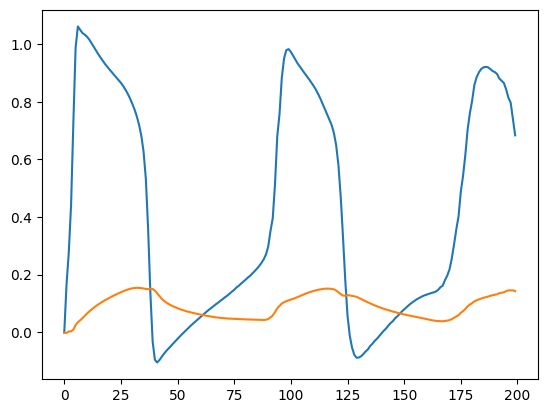

In [48]:

def Modelrun(x,M=model):
   
  
    my2dspace = pt.tensor(x, requires_grad=False).float().cuda()
    M.eval()
    start_time = TIME.time()
    print(np.shape(my2dspace))
    myOutput = M(my2dspace)
    reftime = TIME.time()- start_time
 
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return uu,reftime


from itertools import product
krange = [(0.08 + 0.03 * i * 0.1) for i in range(0, 1)]
vrange = [(0.00 + 0.1 * i * 0.12) for i in range(0, 1)]
urange = [(0.00 + 0.1 * i * 1) for i in range(0, 1)]

t=np.linspace(0,50,200)
param_list = np.array(list(product(t,urange,vrange, krange )))



print(np.shape(param_list))


r,t=Modelrun(param_list)

print(np.shape(r))
plt.plot(r)

In [52]:



from FHNCUDAlib import FHNCUDA
import numpy as np

import time as TIME
x0=param_list[:,1:]
dt,tt=0.0001,50

rate=2000

start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
reftime = TIME.time()- start_time
p=[i/1000 for i in p[0]]
u_ref=np.array(u).flatten()


print("Solving for ",len(x0),"cells in " ,int(np.shape(u_ref)[0]/len(x0)),"timepoints" )
print("Shape ref ",np.shape(u_ref))
print("ref cuda time",p)



start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt*100,rate/100)
cudatime = TIME.time()- start_time
u_num=np.array(u).flatten()
#print(np.unique(t))
p=[i/1000 for i in p[0]]
print("Shape cudapred ",np.shape(u_num))
print("cuda time",p)
print("Error Calculation")
e=((u_ref-u_num)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]
x0 = [item for sublist in x0 for item in sublist]
t = [item for sublist in t for item in sublist]

print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:])

u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")
plt.savefig("aa.png")




e=lambda x:np.array(x).T

invar={"t":e(t )  ,"K":e(x0)   }
out={"x1":e(u_net),       }
out_t={"x1":e(u_num),         }

3
Number of rows in the CSV file:  200 251
Solving for  200 cells in  251 timepoints
Shape ref  (50200,)
ref cuda time [0.00023654400000000002, 0.391367676, 0.010636736]
3
Number of rows in the CSV file:  200 251
Shape cudapred  (50200,)
cuda time [1.8432e-05, 0.034902591999999996, 0.01042656]
Error Calculation
mean 2.4598804780876493e-06
max 0.00045500000000000054
(252,)


AttributeError: 'list' object has no attribute 'eval'

In [13]:
import torch_tensorrt
import time
import torch
m=net(2,2)

print("Begin compiling")
import torch_tensorrt




def benchmark(model, input_shape=(1,2,1), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
           # if i%10==0:
               # print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))
              #  print('Images processed per second=', int(1000*input_shape[0]/(np.mean(timings)*1000)))
   # print("Input shape:", input_data.size())
   # print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

Begin compiling


In [18]:

def compileRT(modelTorch=net(4,2)):
    print("Beg")
    X=np.zeros((4,5))
    model = torch.jit.script(m).eval()  # torch module needs to be in eval (not training) mode



    trt_ts_module = torch_tensorrt.compile(model, inputs = [torch_tensorrt.Input(
            min_shape=(50,100,4),
            opt_shape=(100,100,4),
            max_shape=(150,100,4),
            dtype=torch.float32)],
        enabled_precisions = torch.float32, # Run with FP32
        workspace_size = 1 << 33
    )

    print("Done compiling")
    return trt_ts_module


trt_ts_module=compileRT(torch.jit.script(net(2,4)).cuda())


X=np.zeros((100,100,4))
print(np.shape(X))
torch.cuda.empty_cache()
print(np.shape(X))
  
trt_ts_module.eval()
my2dspace = pt.tensor(X, requires_grad=False).float().cuda()
  
print(np.shape(my2dspace))
myOutput = trt_ts_module(my2dspace)

#print(myOutput)
#print("Done inference")


#benchmark(trt_ts_module,input_shape=(40,2))



Beg


ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: %49 : Tensor = aten::matmul(%x.1, %48): last dimension of input0 = 4 and second to last dimension of input1 = 2 but must match.
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: [graphShapeAnalyzer.cpp::needTypeAndDimensions::2212] Error Code 4: Internal Error (%49 : Tensor = aten::matmul(%x.1, %48): output shape can not be computed)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: [graphShapeAnalyzer.cpp::needTypeAndDimensions::2212] Error Code 4: Internal Error (%49 : Tensor = aten::matmul(%x.1, %48): output shape can not be computed)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: [graphShapeAnalyzer.cpp::needTypeAndDimensions::2212] Error Code 4: Internal Error (%49 : Tensor = aten::matmul(%x.1, %48): output shape can not be computed)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 4: [graphShapeAnalyzer.cpp::needTypeAndDimensions::2212] Error Code 4: Internal Error (%51 : Tensor =

RuntimeError: [Error thrown at core/util/trt_util.cpp:165] pos >= (-d.nbDims - 1) && pos <= d.nbDims ASSERT FAILED at core/util/trt_util.cpp:165, consider filing a bug: https://www.github.com/NVIDIA/Torch-TensorRT/issues
ERROR: Index to unsqueeze is out of bounds. Expected value in range [0, -1], but got 0


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import time as TIME
import torch, gc



gc.collect()
torch.cuda.empty_cache()
    
t=np.linspace(0,10,500)
x=np.linspace(0,1,1000)
X=np.zeros((2,len(t)*len(x)))
    #print(itertools.product(x,t))


model=trt_ts_module

k=torch.jit.script(net(2,2)).cuda()

def eval(M):

    gc.collect()
    torch.cuda.empty_cache()
    
    #print(np.shape(X))
    M.eval()
    my2dspace = pt.tensor(X.T, requires_grad=False).float().cuda()
   
    start_time = TIME.time()
    print(np.shape(my2dspace))

    myOutput = M(my2dspace)
    
    reftime = TIME.time()- start_time
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    #print(uu)
    gc.collect()
    torch.cuda.empty_cache()
    
    return reftime


print(eval(k))
print(eval(model))

gc.collect()
torch.cuda.empty_cache()

NameError: name 'trt_ts_module' is not defined

In [33]:
print("oi")
import torch_tensorrt

import torch
m=net(2,2)

print(m)


trt_model = torch_tensorrt.compile(m, 
    inputs= [torch_tensorrt.Input((2,2))],
    enabled_precisions= { torch_tensorrt.dtype.half} # Run with FP16
)

oi
net(
  (layer0): Linear(in_features=2, out_features=10, bias=True)
  (layer1): Linear(in_features=10, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=10, bias=True)
  (layer10): Linear(in_features=10, out_features=2, bias=True)
)
